## Imports and functions

In [2]:
import datetime
from pathlib import Path
from typing import Dict, List, Union
import warnings
warnings.filterwarnings("ignore")

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams.update({'figure.max_open_warning': 0})
PARAMS = {'legend.fontsize': 'xx-large',
          'legend.title_fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(PARAMS)

TIME_FORMAT = '%Y-%m-%d'
INT_TYPE = 'int32'

In [11]:
factors_temperature.columns.tolist()

['Unnamed: 0',
 'locus_id',
 'fish_group_id',
 'transfer_year',
 'fw_cycle_length',
 'temperature_cleared-2_weeks_before_transfer-cv',
 'temperature_cleared-2_weeks_before_transfer-cv-from_mean',
 'temperature_cleared-2_weeks_before_transfer-cv-from_mean-abs',
 'temperature_cleared-2_weeks_before_transfer-degree_days',
 'temperature_cleared-2_weeks_before_transfer-max',
 'temperature_cleared-2_weeks_before_transfer-max-from_mean',
 'temperature_cleared-2_weeks_before_transfer-max-from_mean-abs',
 'temperature_cleared-2_weeks_before_transfer-mean',
 'temperature_cleared-2_weeks_before_transfer-mean-from_mean',
 'temperature_cleared-2_weeks_before_transfer-mean-from_mean-abs',
 'temperature_cleared-2_weeks_before_transfer-median',
 'temperature_cleared-2_weeks_before_transfer-median-from_mean',
 'temperature_cleared-2_weeks_before_transfer-median-from_mean-abs',
 'temperature_cleared-2_weeks_before_transfer-min',
 'temperature_cleared-2_weeks_before_transfer-min-from_mean',
 'temperature

In [29]:
def load_data(locus_weights_path: Union[str, Path],
              temperature_path: Union[str, Path],
              locus_group_matching_path: Union[str, Path],
              fresh_water_dates_path: Union[str, Path],
              sw_fw_matching_path: Union[str, Path],
              sw_fw_matching_path_with_cnt: Union[str, Path],
              final_locus_weighted_path: Union[str, Path],
              mortality_path: Union[str, Path]) -> Dict[str, pd.DataFrame]:
    
    locus_weights = pd.read_csv(locus_weights_path)
    locus_weights.starttime = pd.to_datetime(locus_weights.starttime, format=TIME_FORMAT)
    locus_weights.endtime = pd.to_datetime(locus_weights.endtime, format=TIME_FORMAT)
    
    temperature = pd.read_csv(temperature_path)
#     temperature.event_date = pd.to_datetime(temperature.event_date, format=TIME_FORMAT)
#     temperature.locus_group_id=temperature.locus_group_id.astype(INT_TYPE)
#     temperature['event_year'] = temperature['event_date'].dt.year

    locus_group_matching = pd.read_csv(locus_group_matching_path)
    locus_group_matching = locus_group_matching.astype(INT_TYPE)

    fresh_water_dates = pd.read_csv(fresh_water_dates_path)
    for d in ['first_movement_date', 'first_feeding_date', 'shipout_date']:
        fresh_water_dates[d] = pd.to_datetime(fresh_water_dates[d], format=TIME_FORMAT)

    sw_fw_matching = pd.read_csv(sw_fw_matching_path)
    sw_fw_matching_with_cnt = pd.read_csv(sw_fw_matching_path_with_cnt)

    sw_fw_cols = ['target_seawater_locus_id',
                  'transport_date',
                  'ponding_date',
                  'pretransfer_fw_locus_population_id',
                  'fish_count_shipped_out',
                  'avg_weight_g_stocked']
    sw_fw_matching = sw_fw_matching[sw_fw_matching.origin_site_type == 'Freshwater'][sw_fw_cols]
    sw_fw_matching.pretransfer_fw_locus_population_id = sw_fw_matching.\
    pretransfer_fw_locus_population_id.astype(INT_TYPE)

    final_locus_weighted = pd.read_csv(final_locus_weighted_path)
    final_locus_weighted.event_date = pd.to_datetime(final_locus_weighted.event_date)

    mortality = pd.read_csv(mortality_path)
    mortality['transfer_date'] = pd.to_datetime(mortality['transfer_date'], format=TIME_FORMAT)
    mortality['transport_year']= mortality['transfer_date'].dt.year


    dataframes = {
        'temperature': temperature,
        'locus_weigts': locus_weights,
        'locus_group_matching': locus_group_matching,
        'final_locus_weighted': final_locus_weighted,
        'fresh_water_dates': fresh_water_dates,
        'sw_fw_matching': sw_fw_matching,
        'sw_fw_matching_with_cnt': sw_fw_matching_with_cnt,
        'mortality': mortality
    }
    
    return dataframes

def weighted_avg(x, weight, factor):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        tmp = x[[weight, factor]].dropna()
        weighted_sum = (tmp[weight] * tmp[factor]).sum()
        count_sum = tmp[weight].sum()
        return weighted_sum / count_sum
    
#this is to not calculate aggregates if at least one value on the main factor column is NaN
def apply_condition(group,main_factor,agg_function):
    if group[main_factor].isnull().any():
        return np.nan
    else:
        return agg_function(group[main_factor])

def create_ph_aggregated_factors(ph_df, main_factor, agg_function, function_name, env_type='ph'):
    """Creates features on final_locus_population_id_level"""
    agg_df = pd.DataFrame()
    
    agg_df[f'{env_type}-transfer_feeding-{function_name}'] = ph_df[before_transfer & after_first_feeding] \
    .groupby('final_locus_population_id').apply(lambda x: apply_condition(x, main_factor, agg_function))
    
    agg_df[f'{env_type}-before_first_feeding-{function_name}'] = ph_df[before_first_feeding] \
    .groupby('final_locus_population_id').apply(lambda x: apply_condition(x, main_factor, agg_function))

    agg_df[f'{env_type}-transfer_vaccination-{function_name}'] = ph_df[before_transfer & after_vaccination]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x, main_factor, agg_function))

    for week in weeks_before_transfer:
        weeks_before_transfer_date = ph_df['shipout_date'] - pd.to_timedelta(week, unit='W')
        condition = ph_df['event_date'] > weeks_before_transfer_date
        agg_df[f'{env_type}-{week}_weeks_before_transfer-{function_name}'] = ph_df[before_transfer & condition]\
        .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x, main_factor, agg_function))

    mean_df = pd.concat([agg_df.mean(), agg_df.std()], axis=1).rename(columns={0: 'mean', 1: 'std'})

    for col in agg_df.columns[:]:
        agg_df[f'{col}-from_mean'] = agg_df[col] - mean_df.loc[col]['mean']
        agg_df[f'{col}-from_mean-abs'] = np.abs(agg_df[col] - mean_df.loc[col]['mean'])

    return agg_df


def create_degree_days_aggregated_factor(ph_df, main_factor, env_type='ph'):
    """Creates features on final_locus_population_id_level"""
    agg_df = pd.DataFrame()
    
    days = ph_df[before_transfer & after_first_feeding].groupby('final_locus_population_id')['event_date'] \
    .agg(['max','min'])
    days['diff'] = (days['max'] - days['min']).dt.days
    degrees = ph_df[before_transfer & after_first_feeding].groupby('final_locus_population_id')[main_factor] \
    .agg(['mean'])
    agg_df['fw_cycle_length'] = days['diff']
    agg_df[f'{env_type}-transfer_feeding-degree_days'] = days['diff'] * degrees['mean']

    days = ph_df[before_transfer & after_vaccination].groupby('final_locus_population_id')['event_date'] \
    .agg(['max','min'])
    days['diff'] = (days['max'] - days['min']).dt.days
    degrees = ph_df[before_transfer & after_vaccination].groupby('final_locus_population_id')[main_factor] \
    .agg(['mean'])
    agg_df[f'{env_type}-transfer_vaccination-degree_days'] = days['diff'] * degrees['mean']

    days = ph_df[before_vaccination & after_first_feeding].groupby('final_locus_population_id')['event_date'] \
    .agg(['max','min'])
    days['diff'] = (days['max'] - days['min']).dt.days
    degrees = ph_df[before_vaccination & after_first_feeding].groupby('final_locus_population_id')[main_factor] \
    .agg(['mean'])
    agg_df[f'{env_type}-vaccination_feeding-degree_days'] = days['diff'] * degrees['mean']

    days = ph_df[before_first_feeding].groupby('final_locus_population_id')['event_date'] \
    .agg(['max','min'])
    days['diff'] = (days['max'] - days['min']).dt.days
    degrees = ph_df[before_first_feeding].groupby('final_locus_population_id')[main_factor] \
    .agg(['mean'])
    agg_df[f'{env_type}-before_first_feeding-degree_days'] = days['diff'] * degrees['mean']

    
    for week in weeks_before_transfer:
        weeks_before_transfer_date = ph_df['shipout_date'] - pd.to_timedelta(week, unit='W')
        condition = ph_df['event_date'] > weeks_before_transfer_date

        days = ph_df[before_transfer & condition].groupby('final_locus_population_id')['event_date'] \
        .agg(['max','min'])
        days['diff'] = (days['max'] - days['min']).dt.days
        degrees = ph_df[before_transfer & condition].groupby('final_locus_population_id')[main_factor] \
        .agg(['mean'])
        agg_df[f'{env_type}-{week}_weeks_before_transfer-degree_days'] = days['diff'] * degrees['mean']

#     mean_df = pd.concat([agg_df.mean(), agg_df.std()], axis=1).rename(columns={0: 'mean', 1: 'std'})
    
#     for col in agg_df.columns[:]:
#         agg_df[f'{col}-from_mean'] = agg_df[col] - mean_df.loc[col]['mean']
#         agg_df[f'{col}-from_mean-abs'] = np.abs(agg_df[col] - mean_df.loc[col]['mean'])

    return agg_df


def create_ph_aggregated_factors_threshold(ph_df, main_factor, lower_bound, upper_bound, agg_function, condition_type, env_type='ph'):
    """Creates features on final_locus_population_id_level"""
    agg_df = pd.DataFrame()
    
    higher_max = f'{env_type}-{condition_type}-higher_max-{upper_bound}'
    lower_min = f'{env_type}-{condition_type}-lower_min-{lower_bound}'
    btw_min_max = f'{env_type}-{condition_type}-btw_min_max-{lower_bound}-{upper_bound}'
    
    relative_higher_max = f'{env_type}-{condition_type}-relative_higher_max-{upper_bound}'
    relative_lower_min = f'{env_type}-{condition_type}-relative_lower_min-{lower_bound}'
    relative_out_min_max = f'{env_type}-{condition_type}-relative_out_min_max-{lower_bound}-{upper_bound}'


    agg_df[higher_max] = ph_df[ph_df[main_factor] > upper_bound]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x,main_factor,agg_function))

    agg_df[lower_min] = ph_df[ph_df[main_factor] < lower_bound]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x,main_factor,agg_function))

    agg_df[btw_min_max] = ph_df[ph_df[main_factor].between(lower_bound, upper_bound)]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x,main_factor,agg_function))

    agg_df['measurements_count'] = ph_df.groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x,main_factor,agg_function))

    agg_df[higher_max] = agg_df[higher_max].fillna(0).astype('int64')
    agg_df[lower_min] = agg_df[lower_min].fillna(0).astype('int64')
    agg_df[btw_min_max] = agg_df[btw_min_max].fillna(0).astype('int64')

    
    agg_df[relative_higher_max] = agg_df[higher_max] / agg_df['measurements_count']
    agg_df[relative_lower_min] =  agg_df[lower_min] /  agg_df['measurements_count']
    agg_df[relative_out_min_max] = 1 - (agg_df[btw_min_max] /agg_df['measurements_count'])
    agg_df.drop(columns='measurements_count', inplace=True)
        
    return agg_df

def create_factors_df(agg_ph_df, factors, key_columns, weight_column, weighted_func):
    """Creates factors df on key_columns level using weight_column to calculate weighted average"""
    factors_dfs = []
    print('Weighting factors')
    for factor in tqdm(factors):
        tmp = agg_ph_df.groupby(key_columns)\
        .apply(weighted_func, weight_column, factor).reset_index().rename(columns={0: factor})
        factors_dfs.append(tmp)

    factor_df = factors_dfs[0]
    for df in factors_dfs[1:]:
        factor_df = factor_df.merge(df, on=key_columns, how='inner')
    return factor_df

def plot_factors(factors_df, path):
    pairplot = sns.pairplot(factors_df[np.append(corr_df.index, 'mortality')], size=(20, 15))
    plt.title('Mortality vs feature pairplot')
    plt.show()

    for ax in pairplot.axes.flatten():
        # rotate x axis labels
        ax.set_xlabel(ax.get_xlabel(), rotation=45)
        # rotate y axis labels
        ax.set_ylabel(ax.get_ylabel(), rotation=0)
        # set y labels alignment
        ax.xaxis.get_label().set_horizontalalignment('right')
        ax.yaxis.get_label().set_horizontalalignment('right')
    pairplot.figure.savefig(path / 'mortality_vs_feature_pairplot.jpg')

def plot_swarm(df, factor, target, bins, y_scale=1):
    sns.set_style("whitegrid")

    arr_for_chart = df.copy()
    arr_for_chart[factor+'_binned'] = pd.cut(df[factor], bins=bins)
    arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100
    x_axis_factor = factor + '_binned'

    plt.figure()
    f, axs = plt.subplots(1, 1, figsize=(18,8), sharex=True)
    box_plot = sns.swarmplot(data=arr_for_chart, x=x_axis_factor, y=target)

    mean_target = arr_for_chart.groupby(x_axis_factor)[target].mean()
    mean_main_factor = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()

#     vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset for display

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,
                      mean_target.iloc[xtick],
                      round(mean_target.iloc[xtick], 2),
                      horizontalalignment='center',
                      size='xx-large',
                      color='black',
                      weight='semibold')
        box_plot.text(xtick,
                      mean_main_factor.iloc[xtick] / y_scale,
                      round(mean_main_factor.iloc[xtick], 2),
                      horizontalalignment='center',
                      size='xx-large',
                      color='darkblue',
                      weight='semibold')
    
    plt.title(f'Swarmplot: {target} vs. {factor}')
    axs.legend(
        arr_for_chart[x_axis_factor].value_counts().sort_index().apply(lambda x: 'Sample count: ' + str(x)),
        loc='upper right'
    )

    f.show()

#     f.savefig(f'swarmplot_{target}_vs_{factor}.jpg')

## Data processing

In [13]:
dataframes = load_data(locus_weights_path='../data/evt_movement_ratio_with_dates.csv',
                       temperature_path='../data/FW_temperature_cleared.csv',
                       locus_group_matching_path='../data/locus_locus_group_matching.csv',
                       fresh_water_dates_path='../data/FW_cycle_dates.csv',
                       sw_fw_matching_path='../data/seawater_freshwater_matching.csv',
                       sw_fw_matching_path_with_cnt='../data/sw_locus_fw_locus_population_with_counts.csv',
                       final_locus_weighted_path='../data/lw_alldates_final.csv', #_locus
                       mortality_path='../data/smolt_dataset_transfers.csv') #_until2023Feb28_narrow

temperature = dataframes['temperature']
locus_weights = dataframes['locus_weigts']
locus_group_matching = dataframes['locus_group_matching']
final_locus_weighted = dataframes['final_locus_weighted']
fresh_water_dates = dataframes['fresh_water_dates']
sw_fw_matching = dataframes['sw_fw_matching']
mortality = dataframes['mortality']
sw_fw_matching_with_cnt = dataframes['sw_fw_matching_with_cnt']

#tgc = pd.read_csv('../data/transfers_until2023Feb28_with_sw_growth_targets.csv')
vaccines = pd.read_csv('../data/vaccines_with_final_locus_population_id.csv')
vaccines['VAC_EVENT_DATE'] = pd.to_datetime(vaccines['VAC_EVENT_DATE'] , format=TIME_FORMAT)
vaccines_agg = pd.DataFrame(vaccines.groupby('FINAL_LOCUS_POPULATION_ID')['VAC_EVENT_DATE'].max())
fresh_water_dates.rename(columns={'pretransfer_fw_locus_population_id': 'final_locus_population_id'}, inplace=True)
sw_fw_matching.transport_date = pd.to_datetime(sw_fw_matching.transport_date, format=TIME_FORMAT)
sw_fw_matching_with_cnt.transfer_date = pd.to_datetime(sw_fw_matching_with_cnt['transfer_date'], format=TIME_FORMAT)
sw_fw_matching_with_cnt['transfer_year'] = sw_fw_matching_with_cnt['transfer_date'].dt.year

temperature.event_date = pd.to_datetime(temperature.event_date, format=TIME_FORMAT)
temperature['event_year'] = temperature['event_date'].dt.year

In [14]:
temperature['event_date'].max()

Timestamp('2023-12-11 00:00:00')

#### Seawater preprocessing

In [15]:
seawater_temperature = pd.read_csv(
    '../data/seawater_temperature__for_transfers_since_2017_only_first_90days_after_transfer_with_fish_group_id.csv',
)
seawater_temperature['min_to_date'] = pd.to_datetime(seawater_temperature['min_to_date'])

seawater_temperature['min_transfer_date'] = pd.to_datetime(seawater_temperature['min_transfer_date'])
seawater_temperature['transfer_year'] = seawater_temperature['min_transfer_date'].dt.year


In [16]:
seawater_temperature['2_weeks_after_transfer'] = seawater_temperature['min_to_date'] + pd.to_timedelta(2, unit='W')


In [17]:
seawater_temperature_first_2_weeks = seawater_temperature[
    seawater_temperature['event_date'] < seawater_temperature['2_weeks_after_transfer']
]
seawater_temperature_first_2_weeks = seawater_temperature_first_2_weeks.groupby(['locus_id', 'to_fish_group_id', 'transfer_year'])['temperature'].mean().reset_index()

seawater_temperature_first_2_weeks.rename(columns={'to_fish_group_id': 'fish_group_id'}, inplace=True)
seawater_temperature_first_2_weeks.rename(columns={'temperature': 'temperature_2_weeks_after_transfer-mean'}, inplace=True)

In [18]:

# seawater_temperature_first_2_weeks = seawater_temperature[
#     seawater_temperature['event_date'] < seawater_temperature['2_weeks_after_transfer']
# ].groupby(['locus_id', 'to_fish_group_id', 'transfer_year']).mean().reset_index()

# seawater_temperature_first_2_weeks.rename(columns={'to_fish_group_id': 'fish_group_id'}, inplace=True)
# seawater_temperature_first_2_weeks.rename(columns={'temperature': 'temperature_2_weeks_after_transfer-mean'}, inplace=True)

In [19]:
temperature = temperature.merge(
    fresh_water_dates,
    how='left',
)

temperature = temperature.merge(
    vaccines_agg,
    left_on='final_locus_population_id',
    right_on='FINAL_LOCUS_POPULATION_ID',
    how='left'
)

temperature['shipout_year'] = temperature['shipout_date'].dt.year

In [20]:
temperature['event_date'].max()

Timestamp('2023-12-11 00:00:00')

In [21]:
mortality_cols = ['locus_id',
                  'fish_group_id',
                  'transfer_year',
                  'transfer_month',
                  'transfer_month_year',
                  'transfer_season',
                  'transfer_season2',
                  'total_count',
                  'total_mortality_perc_90']

sw_cols = ['to_locus_id',
           'to_fish_group_id',
           'transfer_date',
           'from_locus_population_id',
           'from_count_stocking',
           'transfer_year']

mortality_final_locus = mortality[mortality_cols].merge(
    sw_fw_matching_with_cnt[sw_cols],
    left_on=['fish_group_id', 'locus_id','transfer_year'],
    right_on=['to_fish_group_id', 'to_locus_id','transfer_year'],
    how='left'
)

mortality_final_locus['from_locus_population_id'] = mortality_final_locus['from_locus_population_id'].fillna(0).astype('int32')

In [22]:
before_transfer = temperature['event_date'] < temperature['shipout_date']

after_vaccination = temperature['event_date'] > temperature['VAC_EVENT_DATE']
before_vaccination = temperature['event_date'] < temperature['VAC_EVENT_DATE']

after_first_feeding = temperature['event_date'] > temperature['first_feeding_date']
before_first_feeding = temperature['event_date'] <= temperature['first_feeding_date']

six_weeks_condition = temperature['event_date'] > (temperature['shipout_date'] - pd.to_timedelta(6, unit='W'))
eight_weeks_condition = temperature['event_date'] > (temperature['shipout_date'] - pd.to_timedelta(8, unit='W'))
threshold_conditions = {
    '6_weeks_before_transfer': before_transfer & six_weeks_condition,
    '8_weeks_before_transfer': before_transfer & eight_weeks_condition,
    'vaccination_transfer': before_transfer & after_vaccination,
    'first_feeding_transfer': before_transfer & after_first_feeding,
    'before_first_feeding': before_first_feeding,
}

weeks_before_transfer = [2, 4, 6, 8]
#name of column with values of the factor
key_columns = ['locus_id','fish_group_id','transfer_year']

## Factors aggregation

In [36]:
main_factor = 'temperature_cleared'

In [37]:
agg_functions = {
    'mean': np.mean,
    #'min': np.min,
    #'max': np.max,
    #'std': np.std,
    #'cv': lambda x: np.std(x) / np.mean(x),  # coefficient of variation
#     'threshold': np.count_nonzero,
    #'median': np.median
}

In [38]:
if False:
    temperature[main_factor].hist()
    temperature[main_factor].quantile(0.8)
    max_threshold = 14  # quantile 0.8
    min_threshold = 6  # quantile 0.2
    print(f'Min {main_factor} threshold: {min_threshold}, max {main_factor} threshold: {max_threshold}')

In [39]:
temperature['event_date'].max()

Timestamp('2023-12-11 00:00:00')

In [40]:
agg_dfs = []

for name, func in tqdm(agg_functions.items()):
    if name != 'threshold':
        agg_df = create_ph_aggregated_factors(temperature,
                                              main_factor,
                                              agg_function=func,
                                              function_name=name,
                                              env_type=main_factor.lower())
        agg_dfs.append(agg_df)
    else:
        for condition_type, condition in threshold_conditions.items():
            agg_df = create_ph_aggregated_factors_threshold(
                temperature[condition],
                main_factor,
                min_threshold,
                max_threshold,
                agg_function=func,
                condition_type=condition_type,
                env_type=main_factor.lower()
            )
            agg_dfs.append(agg_df)
agg_dfs.append(create_degree_days_aggregated_factor(temperature, main_factor, env_type=main_factor.lower()))
    
agg_df = pd.concat(agg_dfs)

agg_df = agg_df.merge(
    mortality_final_locus[['from_locus_population_id', 'locus_id','fish_group_id', 'transfer_year', 'from_count_stocking']],
    left_on=['final_locus_population_id',],
    right_on=['from_locus_population_id',],
    how='right')

factors = agg_df.columns.difference(
    ['from_locus_population_id', 'locus_id', 'fish_group_id', 'transfer_year', 'from_count_stocking']
)

factors_temperature = create_factors_df(agg_df,
                                        factors,
                                        key_columns, 
                                        weight_column='from_count_stocking',
                                        weighted_func=weighted_avg)
factors_temperature = factors_temperature.merge(
    pd.DataFrame(mortality_final_locus.groupby(key_columns)['total_mortality_perc_90'].mean()),
    on=key_columns,
    how='inner')

#factors_temperature = factors_temperature.merge(
#    pd.DataFrame(tgc.groupby(key_columns)['TGC_SW'].mean()),
#    on=key_columns,
#    how='inner'
#)


100%|██████████| 1/1 [00:14<00:00, 14.51s/it]


Weighting factors


100%|██████████| 30/30 [01:27<00:00,  2.93s/it]


In [42]:
factors_temperature.rename(columns={'total_mortality_perc_90': 'mortality'}, inplace=True)
factors_temperature.to_csv(f'../data/factors_{main_factor.lower()}.csv', index=False)

In [35]:
main_factor

'temperature'

In [43]:
factors_temperature = pd.read_csv(f'../data/factors_{main_factor.lower()}.csv')

In [44]:
factors_temperature = factors_temperature.merge(seawater_temperature_first_2_weeks,
                                                how='inner',
                                                on=['locus_id', 'fish_group_id', 'transfer_year'])

In [45]:
factors_temperature['temperature_fw_sw_diff'] = factors_temperature['temperature_cleared-2_weeks_before_transfer-mean'] - \
factors_temperature['temperature_2_weeks_after_transfer-mean']

In [46]:
targets = pd.read_csv('../data/targets.csv')

In [47]:
factors_temperature

,locus_id,fish_group_id,transfer_year,fw_cycle_length,temperature_cleared-2_weeks_before_transfer-degree_days,temperature_cleared-2_weeks_before_transfer-mean,temperature_cleared-2_weeks_before_transfer-mean-from_mean,temperature_cleared-2_weeks_before_transfer-mean-from_mean-abs,temperature_cleared-4_weeks_before_transfer-degree_days,temperature_cleared-4_weeks_before_transfer-mean,...,temperature_cleared-transfer_feeding-mean-from_mean,temperature_cleared-transfer_feeding-mean-from_mean-abs,temperature_cleared-transfer_vaccination-degree_days,temperature_cleared-transfer_vaccination-mean,temperature_cleared-transfer_vaccination-mean-from_mean,temperature_cleared-transfer_vaccination-mean-from_mean-abs,temperature_cleared-vaccination_feeding-degree_days,mortality,temperature_2_weeks_after_transfer-mean,temperature_fw_sw_diff
0,3046036,11,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007496,12.328571,NaN
1,3046036,1052,2019,43.451183,154.061737,12.838478,-0.836658,0.836658,348.539744,13.405375,...,1.729526,1.729526,582.538993,13.502297,-0.047281,0.217837,NaN,0.003943,11.921429,0.917050
2,3046036,3918,2020,48.000000,150.369231,12.530769,-1.144367,1.144367,327.503704,12.596296,...,0.908247,0.908247,595.578125,12.671875,-0.877704,0.877704,NaN,0.007676,11.546429,0.984341
3,3046036,6165,2023,285.000000,174.553846,14.546154,0.871018,0.871018,368.814815,14.185185,...,-1.479121,1.479121,793.899701,13.779554,0.229976,0.229976,2112.351045,0.005902,12.515714,2.030440
4,3046043,310,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.018394,10.507143,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1400,7205278,6914,2023,285.000000,166.061538,13.838462,0.163326,0.163326,361.255556,13.894444,...,-1.334598,1.334598,841.911673,13.502018,-0.047561,0.047561,2105.604157,0.009679,9.585357,4.253104
1401,7205279,6909,2023,282.000000,154.061538,12.838462,-0.836674,0.836674,316.525926,12.174074,...,-2.122943,2.122943,850.598592,12.151408,-1.398170,1.398170,1845.923077,0.007952,9.608929,3.229533
1402,7205280,6909,2023,273.000000,170.169231,14.180769,0.505633,0.505633,353.214815,13.585185,...,-0.127420,0.127420,872.611432,13.430785,-0.118794,0.118794,2278.595834,0.015256,9.763214,4.417555
1403,7205281,6909,2023,282.000000,161.006543,13.417212,-0.257924,0.439466,323.293633,12.434370,...,-1.942380,1.942380,895.545972,12.375716,-1.173862,1.173862,1851.530453,0.007381,9.608929,3.808283


In [48]:
factors_temperature = factors_temperature.merge(targets[key_columns + ['stocking_weight', 'nSFR']],
                                                how='inner',
                                                on=key_columns)

## Findings

In [49]:
tmp = temperature.merge(mortality_final_locus,
                        left_on='final_locus_population_id',
                        right_on='from_locus_population_id')


factors_temperature = factors_temperature.merge(
    pd.DataFrame(tmp[key_columns+[main_factor]].groupby(key_columns)[main_factor].mean()),
    on=key_columns,
    how='left'
)

### Finding 1: Temperature difference between sea water and fresh water (2 weeks)

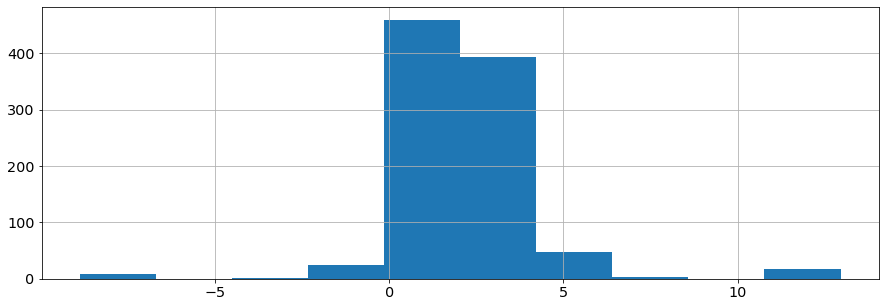

ValueError: Could not interpret value `TGC_SW` for parameter `y`

<Figure size 1080x360 with 0 Axes>

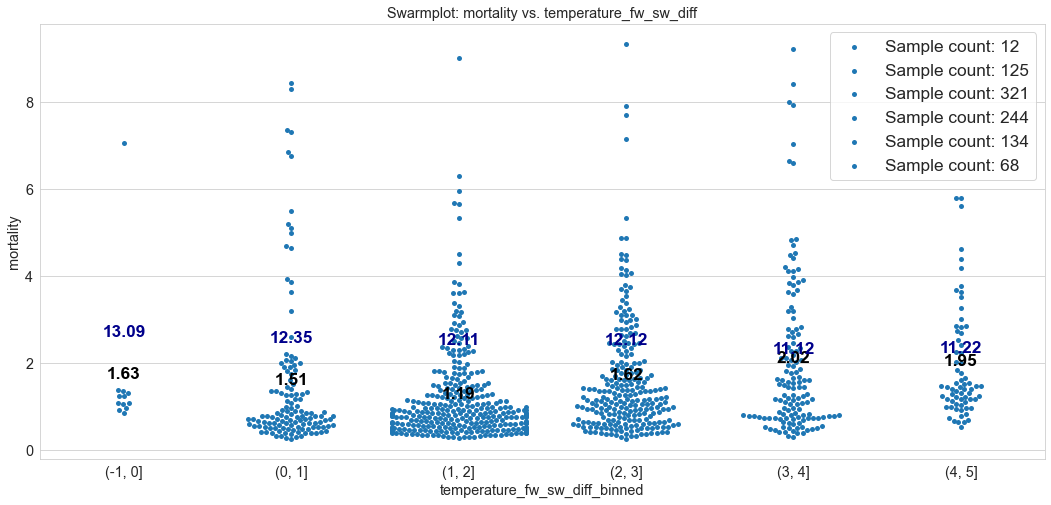

<Figure size 1080x360 with 0 Axes>

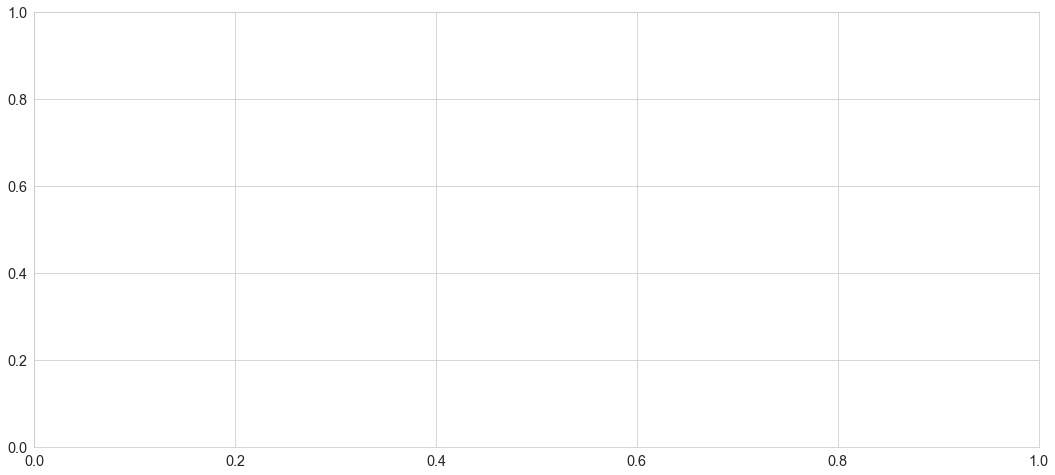

In [50]:
factor = f'temperature_fw_sw_diff'

factors_temperature[factor].hist()
plt.show()

plot_swarm(factors_temperature,
           factor=factor,
           target='mortality',
           bins=(-1, 0, 1, 2, 3, 4, 5),
           y_scale=5)

plot_swarm(factors_temperature,
           factor=factor,
           target='TGC_SW',
           bins=(-1, 0, 1, 2, 3, 4, 5),
           y_scale=5)

### Finding 2: Median temperature

In [ ]:
factor = f'temperature_cleared-transfer_feeding-median'

factors_temperature[factor].hist()
plt.show()

plot_swarm(factors_temperature,
           factor=factor,
           target='mortality',
           bins=(12., 13.5, 14, 14.5, 15),
           y_scale=5)

plot_swarm(factors_temperature,
           factor=factor,
           target='TGC_SW',
           bins=(12., 13.5, 14, 14.5, 15),
           y_scale=5)

### FInding 3: Degree days

In [ ]:
factor = f'temperature_cleared-transfer_feeding-degree_days'

factors_temperature[factor].hist()
plt.show()

plot_swarm(factors_temperature,
           factor=factor,
           target='mortality',
           bins=(3000, 3500, 3750, 4200, 5000),
           y_scale=5)

plot_swarm(factors_temperature,
           factor=factor,
           target='TGC_SW',
           bins=(3000, 3500, 3750, 4200, 5000),
           y_scale=5)

In [ ]:
factor = f'temperature_cleared-transfer_feeding-degree_days'

factors_temperature[factor].hist()
plt.show()

plot_swarm(factors_temperature,
           factor=factor,
           target='nSFR',
           bins=(3000, 3500, 3750, 4200, 5000),
           y_scale=10)

plot_swarm(factors_temperature,
           factor=factor,
           target='stocking_weight',
           bins=(3000, 3500, 3750, 4200, 5000),
           y_scale=0.1)

### Finding 4: Mean temperature 2 weeks before transfer

In [ ]:
factor = f'temperature_cleared-2_weeks_before_transfer-mean'

factors_temperature[factor].hist()
plt.show()

plot_swarm(factors_temperature,
           factor=factor,
           target='mortality',
           bins=(11, 12.5, 13.5, 14, 15),
           y_scale=5)

plot_swarm(factors_temperature,
           factor=factor,
           target='TGC_SW',
           bins=(11, 12.5, 13.5, 14, 15),
           y_scale=5)

In [ ]:
factors_temperature['fw_cycle_length'].hist()
plt.show()

plot_swarm(factors_temperature,
           factor='fw_cycle_length',
           target='mortality',
           bins=(200, 260, 280, 340),
           y_scale=5)

plot_swarm(factors_temperature,
           factor='fw_cycle_length',
           target='TGC_SW',
           bins=(200, 260, 280, 340),
           y_scale=5)

In [22]:
factors_temperature

,locus_id,fish_group_id,transfer_year,fw_cycle_length,temperature_cleared-2_weeks_before_transfer-cv,temperature_cleared-2_weeks_before_transfer-cv-from_mean,temperature_cleared-2_weeks_before_transfer-cv-from_mean-abs,temperature_cleared-2_weeks_before_transfer-degree_days,temperature_cleared-2_weeks_before_transfer-max,temperature_cleared-2_weeks_before_transfer-max-from_mean,...,temperature_cleared-transfer_vaccination-std,temperature_cleared-transfer_vaccination-std-from_mean,temperature_cleared-transfer_vaccination-std-from_mean-abs,temperature_cleared-vaccination_feeding-degree_days,mortality,temperature_2_weeks_after_transfer-mean,temperature_fw_sw_diff,stocking_weight,nSFR,temperature_cleared
0,3046036,11,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.007496,12.328571,NaN,113,0.889235,NaN
1,3046036,1052,2019,43.451183,0.045546,0.019956,0.019956,154.061737,13.800000,-0.441326,...,0.691009,0.139141,0.139141,NaN,0.003943,11.921429,0.917050,123,1.056957,13.541304
2,3046036,3918,2020,48.000000,0.009277,-0.016313,0.016313,150.369231,12.700000,-1.541326,...,0.281163,-0.270705,0.270705,NaN,0.007676,11.546429,0.984341,135,0.852458,12.673000
3,3046036,6165,2023,285.000000,0.023448,-0.002142,0.002142,174.553846,14.900000,0.658674,...,0.587483,0.035614,0.035614,2112.351045,0.005902,12.515714,2.030440,130,0.819303,7.839825
4,3046043,310,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.018394,10.507143,NaN,156,0.823061,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,7205278,6914,2023,285.000000,0.004235,-0.021355,0.021355,166.061538,14.000000,-0.241326,...,0.597225,0.045357,0.045357,2105.604157,0.009679,9.585357,4.253104,156,0.835038,8.632134
1402,7205279,6909,2023,282.000000,0.021874,-0.003716,0.003716,154.061538,13.200000,-1.041326,...,0.607045,0.055176,0.055176,1845.923077,0.007952,9.608929,3.229533,128,0.880448,8.054500
1403,7205280,6909,2023,273.000000,0.029582,0.003992,0.003992,170.169231,14.700000,0.458674,...,0.658666,0.106797,0.106797,2278.595834,0.015256,9.763214,4.417555,173,0.836310,9.381298
1404,7205281,6909,2023,282.000000,0.016089,-0.009501,0.009501,161.006543,13.666589,-0.574736,...,0.837765,0.285896,0.285896,1851.530453,0.007381,9.608929,3.808283,126,0.883235,8.169438


In [52]:

factors_temperature[key_columns + ['temperature_fw_sw_diff',
                                    'temperature_cleared-before_first_feeding-mean',
                                    'temperature_cleared-before_first_feeding-degree_days',
                                    ]].to_csv('../data/significant_factors_temperature.csv')

In [24]:
factors_temperature[[col for col in factors_temperature.columns if col not in ['mortality', 'TGC_SW', 'temperature_cleared', 'stocking_weight', 'nSFR']]].to_csv(f'../data/factors_temperature.csv')